In [106]:
import os
import sys
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import librosa 
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wav
import numpy as np
from timeit import default_timer as timer
%run utils.ipynb

## Implementation on the original Librispeech set.
* The Librispeech dataset is divided into three components based on the hours of audio which are 100 hours, 360 hours and 500 hours. Here we worked with 100 hours of cleaned audio data. 
1. First we make a dataframe and only take the audio files from the <font color=Red>**Librispeech Dataset**</font>.
1. Here we extract the MFCC feature spectrogram from the raw audio using the sample rate of <font color=Red>22050Hz</font>
1. This particular dataset consists of 28539 samples with 251 classes of speakers. Following the normal convention 80% data is used for training and the rest is used to evaluate the model.
1. We are using the same CNN model that is previously used in the Timit dataset. 
| Model | Total Trainable Parameter | Training Acc | Valdiation Acc |
|:-:|:-:|:-:|:-:|
| CNN | 608,718 | 99 | 98 |

In [107]:
filename = "H:/Librispeech/LibriSpeech/train-clean-100/40/121026/40-121026-0000.flac"

In [108]:
ipd.Audio(filename)

In [ ]:
Libri_df=pd.read_csv("H:/Librispeech/LibriSpeech/CHAPTERS.TXT", delimiter="|")
Libri_df.columns =['ID', 'READER', 'MINUTES', 'SUBSET', 'PROJ.',
       'BOOK ID', 'CH. TITLE', 'PROJECT TITLE']

In [ ]:
Libri_df=Libri_df[Libri_df["SUBSET"].str.contains("train-clean-100")]

In [11]:
Libri_df.dtypes

ID                 int64
READER             int64
MINUTES          float64
SUBSET            object
PROJ.              int64
BOOK ID            int64
CH. TITLE         object
PROJECT TITLE     object
dtype: object

In [12]:
list(Libri_df.loc[Libri_df["READER"]==19]["ID"])

[198, 227]

In [13]:
print("Total Number of speakers: ", len(Libri_df["READER"].unique()) )

Total Number of speakers:  251


In [14]:
noOfSpeakers = Libri_df["READER"].unique()

In [56]:
iter_dict ={}
for speaker in noOfSpeakers:
    if speaker not in iter_dict:
        iter_dict[speaker] = []
    sel_rows=Libri_df.loc[Libri_df["READER"]== speaker]
    ids=list(sel_rows["ID"])
    for ID in ids:
        iter_dict[speaker].append(ID)
        
print(iter_dict)

{19: [198, 227], 198: [209, 126831, 129977], 403: [216, 126855, 128339], 89: [218, 219], 40: [222, 121026], 730: [358, 359, 360], 78: [368, 369], 2952: [407, 408, 410], 26: [495, 496], 103: [1240, 1241], 2436: [2476, 2477, 2481], 83: [3054, 9960, 11691], 6019: [3185], 32: [4137, 21625, 21631, 21634], 3807: [4923, 4955], 2136: [5140, 5143, 5147], 3983: [5331, 5371], 2836: [5354, 5355], 1578: [6379, 140045, 140049], 4214: [7146], 2911: [7601, 12359, 15045, 15084], 5322: [7678, 7679, 7680], 7148: [7763, 59157, 82991], 3242: [8112, 67153, 67168], 3112: [9554, 9555], 1970: [10594, 26100, 28415], 4051: [10927, 11217, 11218], 4160: [11549, 11550, 14187], 3235: [11599, 28433, 28452], 4137: [11701, 11702], 3664: [11714, 178355, 178366], 254: [12312, 27760, 127705, 145458], 3830: [12529, 12530, 12531, 12535], 5778: [12761, 54535], 4297: [13006, 13009], 3947: [13260, 13262], 5339: [14133, 14134], 4340: [15220], 4362: [15663], 4397: [15666, 15668, 15678], 5688: [15787, 41232], 4680: [16026, 16041,

In [16]:
# file path H:\Librispeech\LibriSpeech\train-clean-100\19\198
# collecting all the filepath from the folders
ori_path = "H:/Librispeech/LibriSpeech/train-clean-100/"
all_files=[]
for speaker in noOfSpeakers:
    ids=iter_dict[speaker]
    for ID in ids:
        full_path = ori_path+str(speaker)+"/"+str(ID)
        files= os.listdir(full_path)
        for file in files:
            all_files.append(full_path+"/"+file)

In [17]:
speaker=all_files[0]
parts=speaker.split("/")
print("Reader id is: ",parts[4])

Reader id is:  19


In [18]:
len(all_files) #Number of files

29125

In [20]:
all_files[200:210]

['H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0047.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0048.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0049.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0050.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0051.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0052.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831-0053.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/126831/198-126831.trans.txt',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/129977/198-129977-0000.flac',
 'H:/Librispeech/LibriSpeech/train-clean-100/198/129977/198-129977-0001.flac']

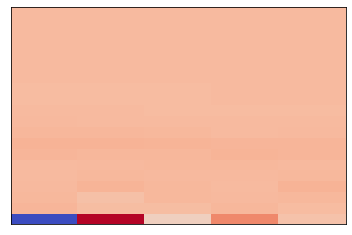

In [21]:
file_1="H:/Librispeech/LibriSpeech/train-clean-100/198/129977/198-129977-0001.flac"
a = extract_MFCC(file_1)
librosa.display.specshow(np.reshape(a, (20,5)) )
ipd.Audio(file_1)

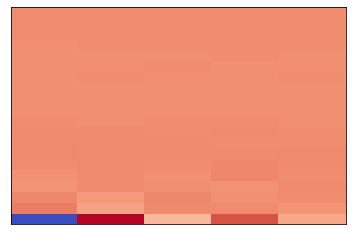

In [22]:
file_2="H:/Librispeech/LibriSpeech/train-clean-100/7078/271888/7078-271888-0027.flac"
b= extract_MFCC(file_2)
librosa.display.specshow(np.reshape(b, (20,5)) )
ipd.Audio(file_2)

In [23]:
Libri_df.head()

ID  READER  MINUTES              SUBSET  PROJ.  BOOK ID     CH. TITLE  \
3   198      19     8.42   train-clean-100      219      121   Chapter 01    
11  209     198     8.20   train-clean-100      219      121   Chapter 12    
15  216     403     6.30   train-clean-100      219      121   Chapter 19    
16  218      89    12.78   train-clean-100      219      121   Chapter 21    
17  219      89    12.30   train-clean-100      219      121   Chapter 22    

        PROJECT TITLE  
3    Northanger Abbey  
11   Northanger Abbey  
15   Northanger Abbey  
16   Northanger Abbey  
17   Northanger Abbey

In [26]:
mfcc_features = []
exceptions=0

start_time = timer()
for file in all_files:
    i=1
    # get file path
    try: # extract features
        mfccs = extract_MFCC(file)
        features=np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(file)
        exceptions += 1
        continue
        
    if i%500==0:
        print("Finished extracting Mfcc from 500 files")
    
    print("Finished extracting MFCC from a file")
   
    label = file.split("/")[4]
    mfcc_features.append([features, features.shape, label])
    i+=1    
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
F

C:\Users\pc\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
F

In [27]:
cols = ["Features", "Feature_shape", "Label"]
libri_processed_df = pd.DataFrame(data= mfcc_features, columns= cols)
libri_processed_df.head()

Features Feature_shape Label
0  [[-1.0, 1.0, -1.0, 1.0, -1.0], [0.0026961232, ...       (20, 5)    19
1  [[-1.0, 1.0, -1.0, 1.0, -1.0], [-0.0072754943,...       (20, 5)    19
2  [[-1.0, 1.0, -1.0, 1.0, -1.0], [-0.013126501, ...       (20, 5)    19
3  [[-1.0, 1.0, -1.0, 1.0, -1.0], [-0.009133968, ...       (20, 5)    19
4  [[-1.0, 1.0, -1.0, 1.0, -1.0], [-0.008753015, ...       (20, 5)    19

In [28]:
from sklearn.utils import shuffle
libri_processed_df=shuffle(libri_processed_df, random_state=42)

In [29]:
print("The dimension of the DataFrame", libri_processed_df.shape)
libri_processed_df.head()

The dimension of the DataFrame (28539, 3)


Features Feature_shape Label
7578   [[-1.0, 1.0, -1.0, 1.0, -1.0], [-0.023142198, ...       (20, 5)  7178
14971  [[-1.0, 1.0, -0.40585002, 1.0, 0.22631353], [0...       (20, 5)  1502
11490  [[-1.0, 1.0, -1.0, 1.0, 0.044151694], [0.01522...       (20, 5)  7113
9233   [[-1.0, 1.0, -1.0, 1.0, -1.0], [0.006073036, -...       (20, 5)  6078
20407  [[-1.0, 1.0, -1.0, 1.0, -1.0], [0.034086484, -...       (20, 5)  1553

In [30]:
print("The total number of classes in the Dataset are: ", len(libri_processed_df.Label.unique()))

The total number of classes in the Dataset are:  251


In [31]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 

X = np.array(libri_processed_df.Features.tolist())
X[:10]

array([[[-1.00000000e+00,  1.00000000e+00, -1.00000000e+00,
          1.00000000e+00, -1.00000000e+00],
        [-2.31421981e-02,  4.05472107e-02, -3.37470084e-01,
          3.61916237e-02, -9.60135385e-02],
        [-9.18709859e-03, -2.91910805e-02, -1.35964215e-01,
         -1.01501636e-01,  1.00257970e-01],
        [-1.09800799e-02, -3.09905615e-02,  2.16149643e-01,
         -1.32929459e-01,  2.59496365e-02],
        [ 1.55723060e-03, -3.09426766e-02, -3.99640203e-03,
          2.87763737e-02, -1.04014672e-01],
        [ 4.82588727e-03,  4.67970110e-02,  4.83507872e-01,
          3.06564838e-01,  6.88359678e-01],
        [ 2.51257364e-02,  8.00873339e-02,  7.35663891e-01,
          1.41536549e-01,  2.10411802e-01],
        [ 7.41420500e-03,  1.77604314e-02,  2.52346337e-01,
          3.67800780e-02, -1.36731444e-02],
        [-3.01957643e-03, -5.12497500e-03,  8.15802952e-04,
         -3.48417908e-02, -7.16875866e-02],
        [-3.43005476e-03, -1.98107548e-02, -2.88285345e-01,
    

In [32]:
le=LabelEncoder()
le.fit(libri_processed_df.Label)
y= to_categorical(le.transform(libri_processed_df.Label))
print(y.shape)

(28539, 251)


In [33]:
print(X.shape)
print(y.shape)

(28539, 20, 5)
(28539, 251)


In [34]:
X= np.reshape(X, (28539,20, 5, 1))

In [35]:
X.shape

(28539, 20, 5, 1)

In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [37]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(22831, 20, 5, 1) (22831, 251) (5708, 20, 5, 1) (5708, 251)


In [38]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

In [39]:
model=Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
 
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())


model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(251,activation="softmax"))

In [40]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 2, 128)         512       
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0

In [41]:
start_time=timer()
history=model.fit(x_train,y_train,batch_size=50,epochs=30, validation_data=(x_test, y_test))
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/30
457/457 [==============================] - 36s 78ms/step - loss: 3.9354 - accuracy: 0.1185 - val_loss: 2.4880 - val_accuracy: 0.4872
Epoch 2/30
457/457 [==============================] - 34s 73ms/step - loss: 2.0727 - accuracy: 0.4200 - val_loss: 1.0126 - val_accuracy: 0.7314
Epoch 3/30
457/457 [==============================] - 33s 73ms/step - loss: 1.4147 - accuracy: 0.5854 - val_loss: 0.5626 - val_accuracy: 0.8429
Epoch 4/30
457/457 [==============================] - 33s 72ms/step - loss: 1.1099 - accuracy: 0.6690 - val_loss: 0.4020 - val_accuracy: 0.8914
Epoch 5/30
457/457 [==============================] - 33s 73ms/step - loss: 0.8916 - accuracy: 0.7334 - val_loss: 0.4442 - val_accuracy: 0.8740
Epoch 6/30
457/457 [==============================] - 33s 72ms/step - loss: 0.7694 - accuracy: 0.7674 - val_loss: 0.2880 - val_accuracy: 0.9189
Epoch 7/30
457/457 [==============================] - 33s 72ms/step - loss: 0.6963 - accuracy: 0.7887 - val_loss: 0.2452 - val_accuracy:

In [42]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100)

test_score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", test_score[1]*100)

Training Accuracy:  99.26415681838989
Testing Accuracy:  97.84513115882874


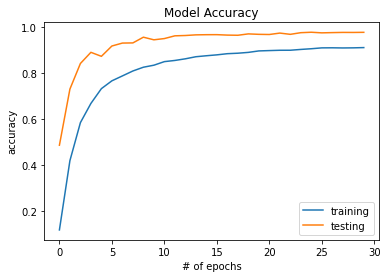

In [43]:
#plot 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("# of epochs")
plt.ylabel("accuracy")
plt.legend(["training", "testing"])
plt.show()

### Implementing the customized LibriSpeech (Openset)
* The customized LibriSpeech dataset by the author Marco Ravanelli contains 21933 audio samples where the total number of classes are 2484.
* From 21933 samples, 17495 samples are used for training and the rest is used for testing. 
| Model | Total Trainable Parameter | Training Acc | Valdiation Acc |
|:-:|:-:|:-:|:-:|
| CNN | 1,645,748 | 85.5 | 65 |

In [24]:
%run utils.ipynb

In [25]:
pathway = "H:/Librispeaker/Librispeech_spkid_sel"
audio_files = os.listdir(pathway)
audio_files.pop()

'split_spk_list'

In [26]:
print(len(audio_files)) #Total number of audio samples 

21933


In [27]:
print(audio_files[0])

100-121669-0008-1.wav


In [28]:
#Format -- 100-121669-0008-1.wav
labels=[]
for audio in audio_files:
    labels.append(audio.split("-")[0])

In [29]:
labels=np.array(labels)
print(len(labels))

21933


In [30]:
print("Total number of speakers in the dataset are : {}".format(len(np.unique(labels))) )

Total number of speakers in the dataset are : 2484


In [31]:
mask = np.random.choice([True, False], size=21933, p=[0.8, 0.2])

In [32]:
audio_files = np.array(audio_files)

In [33]:
training_samples = audio_files[mask]
training_labels = labels[mask]
testing_samples = audio_files[~mask]
testing_labels = labels[~mask]

In [34]:
print(training_samples.shape)
print(training_labels.shape)
print(testing_samples.shape)
print(testing_labels.shape)

(17495,)
(17495,)
(4438,)
(4438,)


In [35]:
mfcc_features = []
exceptions=0

start_time = timer()
ori_path = "H:/Librispeaker/Librispeech_spkid_sel/"
i=0
for file in training_samples:
    # get file path
    try: # extract features
        file = ori_path+file
        mfccs = extract_MFCC(file)
        features= np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(file)
        exceptions += 1
        continue
        
    if (i+1)%500==0:
        print("Finished extracting Mfcc from 500 files")
    
    print("Finished extracting MFCC from a file")
   
    label = training_labels[i]
    mfcc_features.append([features, features.shape, label])
    i+=1    
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
F

In [39]:
cols = ["features", "feature_shape", "label"]
processed_df = pd.DataFrame(data=mfcc_features, columns=cols)
processed_df.head()

features feature_shape label
0  [[-265.17963, 120.03614, -58.85669, 22.741808,...       (20, 5)   100
1  [[-243.94743, 130.2639, -50.3534, 28.25353, -2...       (20, 5)   100
2  [[-288.67026, 123.74009, -71.14157, 34.55552, ...       (20, 5)   100
3  [[-265.8529, 125.62632, -63.725056, 25.14218, ...       (20, 5)   100
4  [[-227.56291, 120.01133, -60.117493, 33.176025...       (20, 5)   100

In [47]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 

x_train= np.reshape(np.array(processed_df.features.tolist()) , (17495, 20, 5, 1) )
le=LabelEncoder()
y_train= to_categorical(le.fit_transform(processed_df.label))

In [49]:
print(x_train.shape)
print(y_train.shape)

(17495, 20, 5, 1)
(17495, 2484)


In [51]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

In [52]:
#building the model with softmax loss
model_open=Sequential()
model_open.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model_open.add(MaxPooling2D(padding="same"))

model_open.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_open.add(MaxPooling2D(padding="same"))
model_open.add(Dropout(0.3))
 
model_open.add(BatchNormalization())

model_open.add(GlobalAveragePooling2D())


model_open.add(Dense(256,activation="relu"))
model_open.add(Dropout(0.5))

model_open.add(Dense(512,activation="relu"))
model_open.add(Dropout(0.5))

model_open.add(Dense(2484,activation="softmax"))

In [53]:
model_open.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_open.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 2, 128)         512       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)              

In [54]:
start_time=timer()
history=model_open.fit(x_train,y_train,batch_size=50,epochs=500)
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/500
350/350 [==============================] - 38s 108ms/step - loss: 7.8236 - accuracy: 2.8580e-04
Epoch 2/500
350/350 [==============================] - 32s 91ms/step - loss: 7.5530 - accuracy: 0.0013
Epoch 3/500
350/350 [==============================] - 32s 93ms/step - loss: 7.0830 - accuracy: 0.0040
Epoch 4/500
350/350 [==============================] - 32s 91ms/step - loss: 6.5897 - accuracy: 0.0095
Epoch 5/500
350/350 [==============================] - 34s 96ms/step - loss: 6.1490 - accuracy: 0.0141
Epoch 6/500
350/350 [==============================] - 37s 106ms/step - loss: 5.7993 - accuracy: 0.0219
Epoch 7/500
350/350 [==============================] - 37s 106ms/step - loss: 5.5036 - accuracy: 0.0292
Epoch 8/500
350/350 [==============================] - 38s 108ms/step - loss: 5.2395 - accuracy: 0.0388
Epoch 9/500
350/350 [==============================] - 37s 106ms/step - loss: 5.0331 - accuracy: 0.0476
Epoch 10/500
350/350 [==============================] - 34s 97ms

In [55]:
# Building an intermediate model with the trained data 
from keras.models import Model 
intermediate_open_model = Model(inputs = model_open.input ,outputs = model_open.layers[-2].output )

#### Extracting the mfcc_features from the testing samples 

In [56]:
test_features = []
exceptions=0

start_time = timer()
ori_path = "H:/Librispeaker/Librispeech_spkid_sel/"
i=0
for file in testing_samples:
    # get file path
    try: # extract features
        file = ori_path+file
        mfccs = extract_MFCC(file)
        features= np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(file)
        exceptions += 1
        continue
        
    if (i+1)%500==0:
        print("Finished extracting Mfcc from 500 files")
    
    print("Finished extracting MFCC from a file")
   
    label = testing_labels[i]
    test_features.append([features, features.shape, label])
    i+=1    
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
F

In [58]:
cols = ["features", "shape", "label"]
features_df = pd.DataFrame(data= test_features, columns = cols)
print(features_df.shape)
features_df.head()

(4438, 3)


features    shape label
0  [[-232.6032, 121.171715, -64.00914, 30.59485, ...  (20, 5)   100
1  [[-229.35352, 124.014885, -81.57276, 35.280083...  (20, 5)   100
2  [[-252.33183, 135.25822, -50.58023, 1.6413383,...  (20, 5)   100
3  [[-249.972, 112.87477, -53.86084, 26.364218, -...  (20, 5)   100
4  [[-238.23407, 166.77249, -17.16909, 48.46359, ...  (20, 5)  1001

In [59]:
x_test = np.reshape(np.array(features_df["features"].tolist()), (4438, 20, 5, 1) )
encod = LabelEncoder()
y_test = to_categorical(encod.fit_transform(features_df["label"]))
y_test.shape

(4438, 2131)

In [68]:
predictions= intermediate_open_model.predict(x_test)

In [69]:
predictions[10].shape

(512,)

In [72]:
y_true = np.argmax(y_test, axis=1)

In [73]:
y_true

array([   0,    0,    0, ..., 2129, 2130, 2130], dtype=int64)

In [75]:
(list(y_true)).count(0)

4

In [86]:
%run utils.ipynb
acc = libri_calculate_accuracy(x_test, y_test, intermediate_open_model, similarity="cosine")

Calculating the 0 th sample
[(0.8472712635993958, 0, 0), (0.8122272491455078, 0, 2116), (0.8036121726036072, 0, 2116)]
Calculating the 1 th sample
[(0.7188958525657654, 3, 3)]
Calculating the 2 th sample
[(0.9566879272460938, 8, 8), (0.8080340623855591, 8, 8)]
Calculating the 3 th sample
[]
Calculating the 4 th sample
[]
Calculating the 5 th sample
[]
Calculating the 6 th sample
[(0.7889316082000732, 30, 143)]
Calculating the 7 th sample
[(0.9337866306304932, 35, 35)]
Calculating the 8 th sample
[(0.7497454285621643, 41, 41)]
Calculating the 9 th sample
[(0.8275092840194702, 46, 46)]
Calculating the 10 th sample
[(0.8050805926322937, 52, 206)]
Calculating the 11 th sample
[(0.9029151797294617, 57, 57), (0.7739740610122681, 57, 1961)]
Calculating the 12 th sample
[(0.8434267044067383, 63, 63), (0.7319127917289734, 63, 1255), (0.7167561054229736, 63, 1255)]
Calculating the 13 th sample
[(0.8755327463150024, 67, 67), (0.8157488703727722, 67, 2041), (0.7291275858879089, 67, 67)]
Calculatin

In [88]:
print(acc)

0.6469002695417789


### Implementation on the customized LibriSpeech(Closed set)
* The total samples of 21933 is divided into training and testing sets using a ratio of 80:20 where 17546 samples are used for training and the rest is used to evaluate the model's performance.
| Model | Total Trainable Parameter | Training Acc | Valdiation Acc |
|:-:|:-:|:-:|:-:|
| CNN | 1,645,748 | 99 | 85 |


In [89]:
print(audio_files.shape)
print(labels.shape)

(21933,)
(21933,)


In [90]:
print(labels[:10])

['100' '100' '100' '100' '100' '100' '100' '100' '100' '100']


In [91]:
mfcc_features = []
exceptions=0

start_time = timer()
ori_path = "H:/Librispeaker/Librispeech_spkid_sel/"
i=0
for file in audio_files:
    # get file path
    try: # extract features
        file = ori_path+file
        mfccs = extract_MFCC(file)
        features= np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(file)
        exceptions += 1
        continue
        
    if (i+1)%500==0:
        print("Finished extracting Mfcc from 500 files")
    
    print("Finished extracting MFCC from a file")
   
    label = labels[i]
    mfcc_features.append([features, features.shape, label])
    i+=1    
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
Finished extracting MFCC from a file
F

In [92]:
cols = ["features", "feature_shape", "label"]
processed_df = pd.DataFrame(data=mfcc_features, columns=cols)
processed_df.head()

features feature_shape label
0  [[-232.6032, 121.171715, -64.00914, 30.59485, ...       (20, 5)   100
1  [[-265.17963, 120.03614, -58.85669, 22.741808,...       (20, 5)   100
2  [[-229.35352, 124.014885, -81.57276, 35.280083...       (20, 5)   100
3  [[-243.94743, 130.2639, -50.3534, 28.25353, -2...       (20, 5)   100
4  [[-288.67026, 123.74009, -71.14157, 34.55552, ...       (20, 5)   100

In [95]:
processed_df.shape

(21933, 3)

In [93]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 

X= np.reshape(np.array(processed_df.features.tolist()) , (21933, 20, 5, 1) )
le=LabelEncoder()
y= to_categorical(le.fit_transform(processed_df.label))

In [96]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
y_train.shape

(17546, 2484)

In [98]:
model=Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
 
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())


model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(2484,activation="softmax"))

In [99]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 2, 128)         512       
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)              

In [102]:
start_time=timer()
history=model.fit(x_train,y_train,batch_size=50,epochs=440, validation_data=(x_test, y_test))
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/440
351/351 [==============================] - 43s 122ms/step - loss: 1.7892 - accuracy: 0.5132 - val_loss: 1.3763 - val_accuracy: 0.6927
Epoch 2/440
351/351 [==============================] - 37s 105ms/step - loss: 1.7666 - accuracy: 0.5207 - val_loss: 1.2910 - val_accuracy: 0.6948
Epoch 3/440
351/351 [==============================] - 36s 102ms/step - loss: 1.7247 - accuracy: 0.5285 - val_loss: 1.3705 - val_accuracy: 0.6822
Epoch 4/440
351/351 [==============================] - 36s 103ms/step - loss: 1.7262 - accuracy: 0.5266 - val_loss: 1.2411 - val_accuracy: 0.7210
Epoch 5/440
351/351 [==============================] - 38s 110ms/step - loss: 1.7249 - accuracy: 0.5243 - val_loss: 1.2274 - val_accuracy: 0.7121
Epoch 6/440
351/351 [==============================] - 38s 108ms/step - loss: 1.6657 - accuracy: 0.5379 - val_loss: 1.2518 - val_accuracy: 0.7046
Epoch 7/440
351/351 [==============================] - 37s 105ms/step - loss: 1.6666 - accuracy: 0.5370 - val_loss: 1.2885 -

In [105]:
print("Training Accuracy: ", model.evaluate(x_train, y_train)[1]*100)
print("Testing Accuracy: ", model.evaluate(x_test, y_test)[1]*100)

549/549 [==============================] - 15s 27ms/step - loss: 0.0077 - accuracy: 0.9997
Training Accuracy:  99.96580481529236
138/138 [==============================] - 3s 22ms/step - loss: 0.8072 - accuracy: 0.8496
Testing Accuracy:  84.9555492401123
